In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib as mpl
import plot_utils

In [2]:
methods = {
    'n_3r1i': '3 dims\n1 answer',
    'n_1r1i': '1 dim\n1 answer',
    'n_1r10i': '1 dim\n10 answers',
    'n_1r20i': '1 dim\n20 answers',
    'n_1r50i': '1 dim\n50 answers',
    's_1r20i': '1 dim\n20 answers\n10 samples',
    'n_1r20i_numeric': '1 dim\n20 answers\nrating-only',
    's_1r20i_numeric': '1 dim\n20 answers\nrating-only\n10 samples',}

In [3]:
comparisons = {
    ('n_1r1i', 'n_3r1i'): 'Number of dimensions',
    ('n_1r1i', 'n_1r10i', 'n_1r20i', 'n_1r50i'): 'Number of answers',
    ('n_1r20i', 's_1r20i', 'n_1r20i_numeric', 's_1r20i_numeric'): 'Samples and rating-only prompts'
}

short_titles = {
    'Number of dimensions': '# dimensions',
    'Number of answers': '# answers',
    'Samples and rating-only prompts': 'Samples / rating-only'
}

In [4]:
measures = ('novelty', 'feasibility', 'value')

In [5]:
pearson = pd.DataFrame(columns=measures, dtype=float)
spearman = pd.DataFrame(columns=measures, dtype=float)

In [6]:
squid = []
for method, name in methods.items():
    data = pd.read_excel(f'elo.{method}.xlsx')
    for key in measures:
        if key == 'value':
            mask = (data[key]>0) & (data[key]<100_000)
        else:
            mask = data.index>=0
        spearman.loc[name, key] = stats.spearmanr(data[mask][[key.capitalize(), key]]).statistic
        pearson.loc[name, key] = stats.pearsonr(data[mask][key.capitalize()], data[mask][key]).statistic

    for qid in data['Question id'].unique():
        qmask = data['Question id'] == qid
        entry = {'method': name}
        for key in measures:
            mask = qmask
            if key == 'value':
                mask &= (data[key]>0) & (data[key]<100_000)

            entry[key] = stats.spearmanr(data[mask][[key.capitalize(), key]]).statistic
        squid.append(entry)
spearman_qid = pd.DataFrame(squid)

In [7]:
pearson

,novelty,feasibility,value
3 dims\n1 answer,0.500378,0.537547,0.165868
1 dim\n1 answer,0.536213,0.593793,0.140135
1 dim\n10 answers,0.593916,0.583473,0.244707
1 dim\n20 answers,0.612314,0.557160,0.240666
1 dim\n50 answers,0.591188,0.560093,0.269945
1 dim\n20 answers\n10 samples,0.624988,0.583316,0.280814
1 dim\n20 answers\nrating-only,0.338050,0.632966,0.252737
1 dim\n20 answers\nrating-only\n10 samples,0.486418,0.680751,0.194906


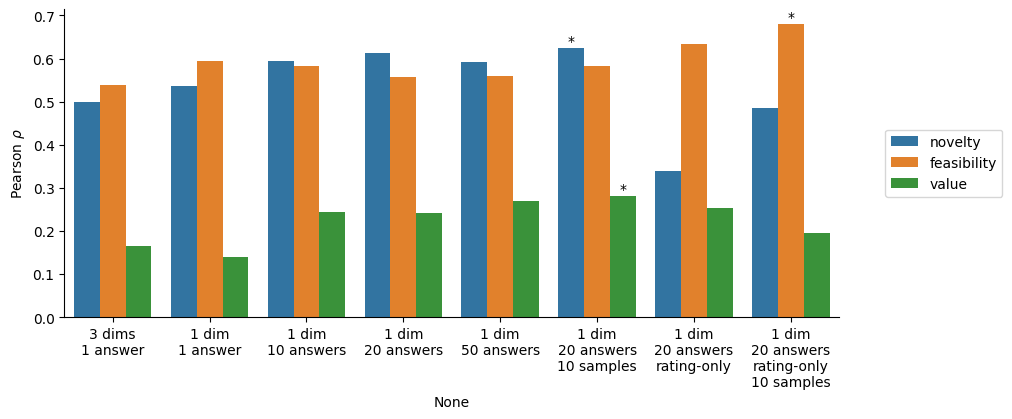

In [8]:
fig, ax = plt.subplots(figsize=(10,4))

long = pearson.melt(value_name='correlation', var_name='measure', ignore_index=False)

imax = [i*len(pearson) + pearson[col].astype('float').argmax() for i, col in enumerate(pearson.columns)]
labels = ['*' if i in imax else '' for i in range(len(long))]

sns.barplot(long, x=long.index, y='correlation', hue='measure', ax=ax)
for i, col in enumerate(pearson.columns):
    jmax = pearson[col].astype('float').argmax()
    labels = ['*' if j == jmax else '' for j in range(len(pearson))]
    ax.bar_label(ax.containers[i], labels)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
ax.set_ylabel('Pearson $\\rho$')
sns.despine(ax=ax)


In [9]:
spearman

,novelty,feasibility,value
3 dims\n1 answer,0.490177,0.552352,0.242438
1 dim\n1 answer,0.545600,0.653976,0.233596
1 dim\n10 answers,0.599273,0.610616,0.294972
1 dim\n20 answers,0.621594,0.587233,0.322606
1 dim\n50 answers,0.602289,0.592486,0.316815
1 dim\n20 answers\n10 samples,0.619451,0.606489,0.354466
1 dim\n20 answers\nrating-only,0.375557,0.651564,0.316294
1 dim\n20 answers\nrating-only\n10 samples,0.504823,0.678231,0.298247


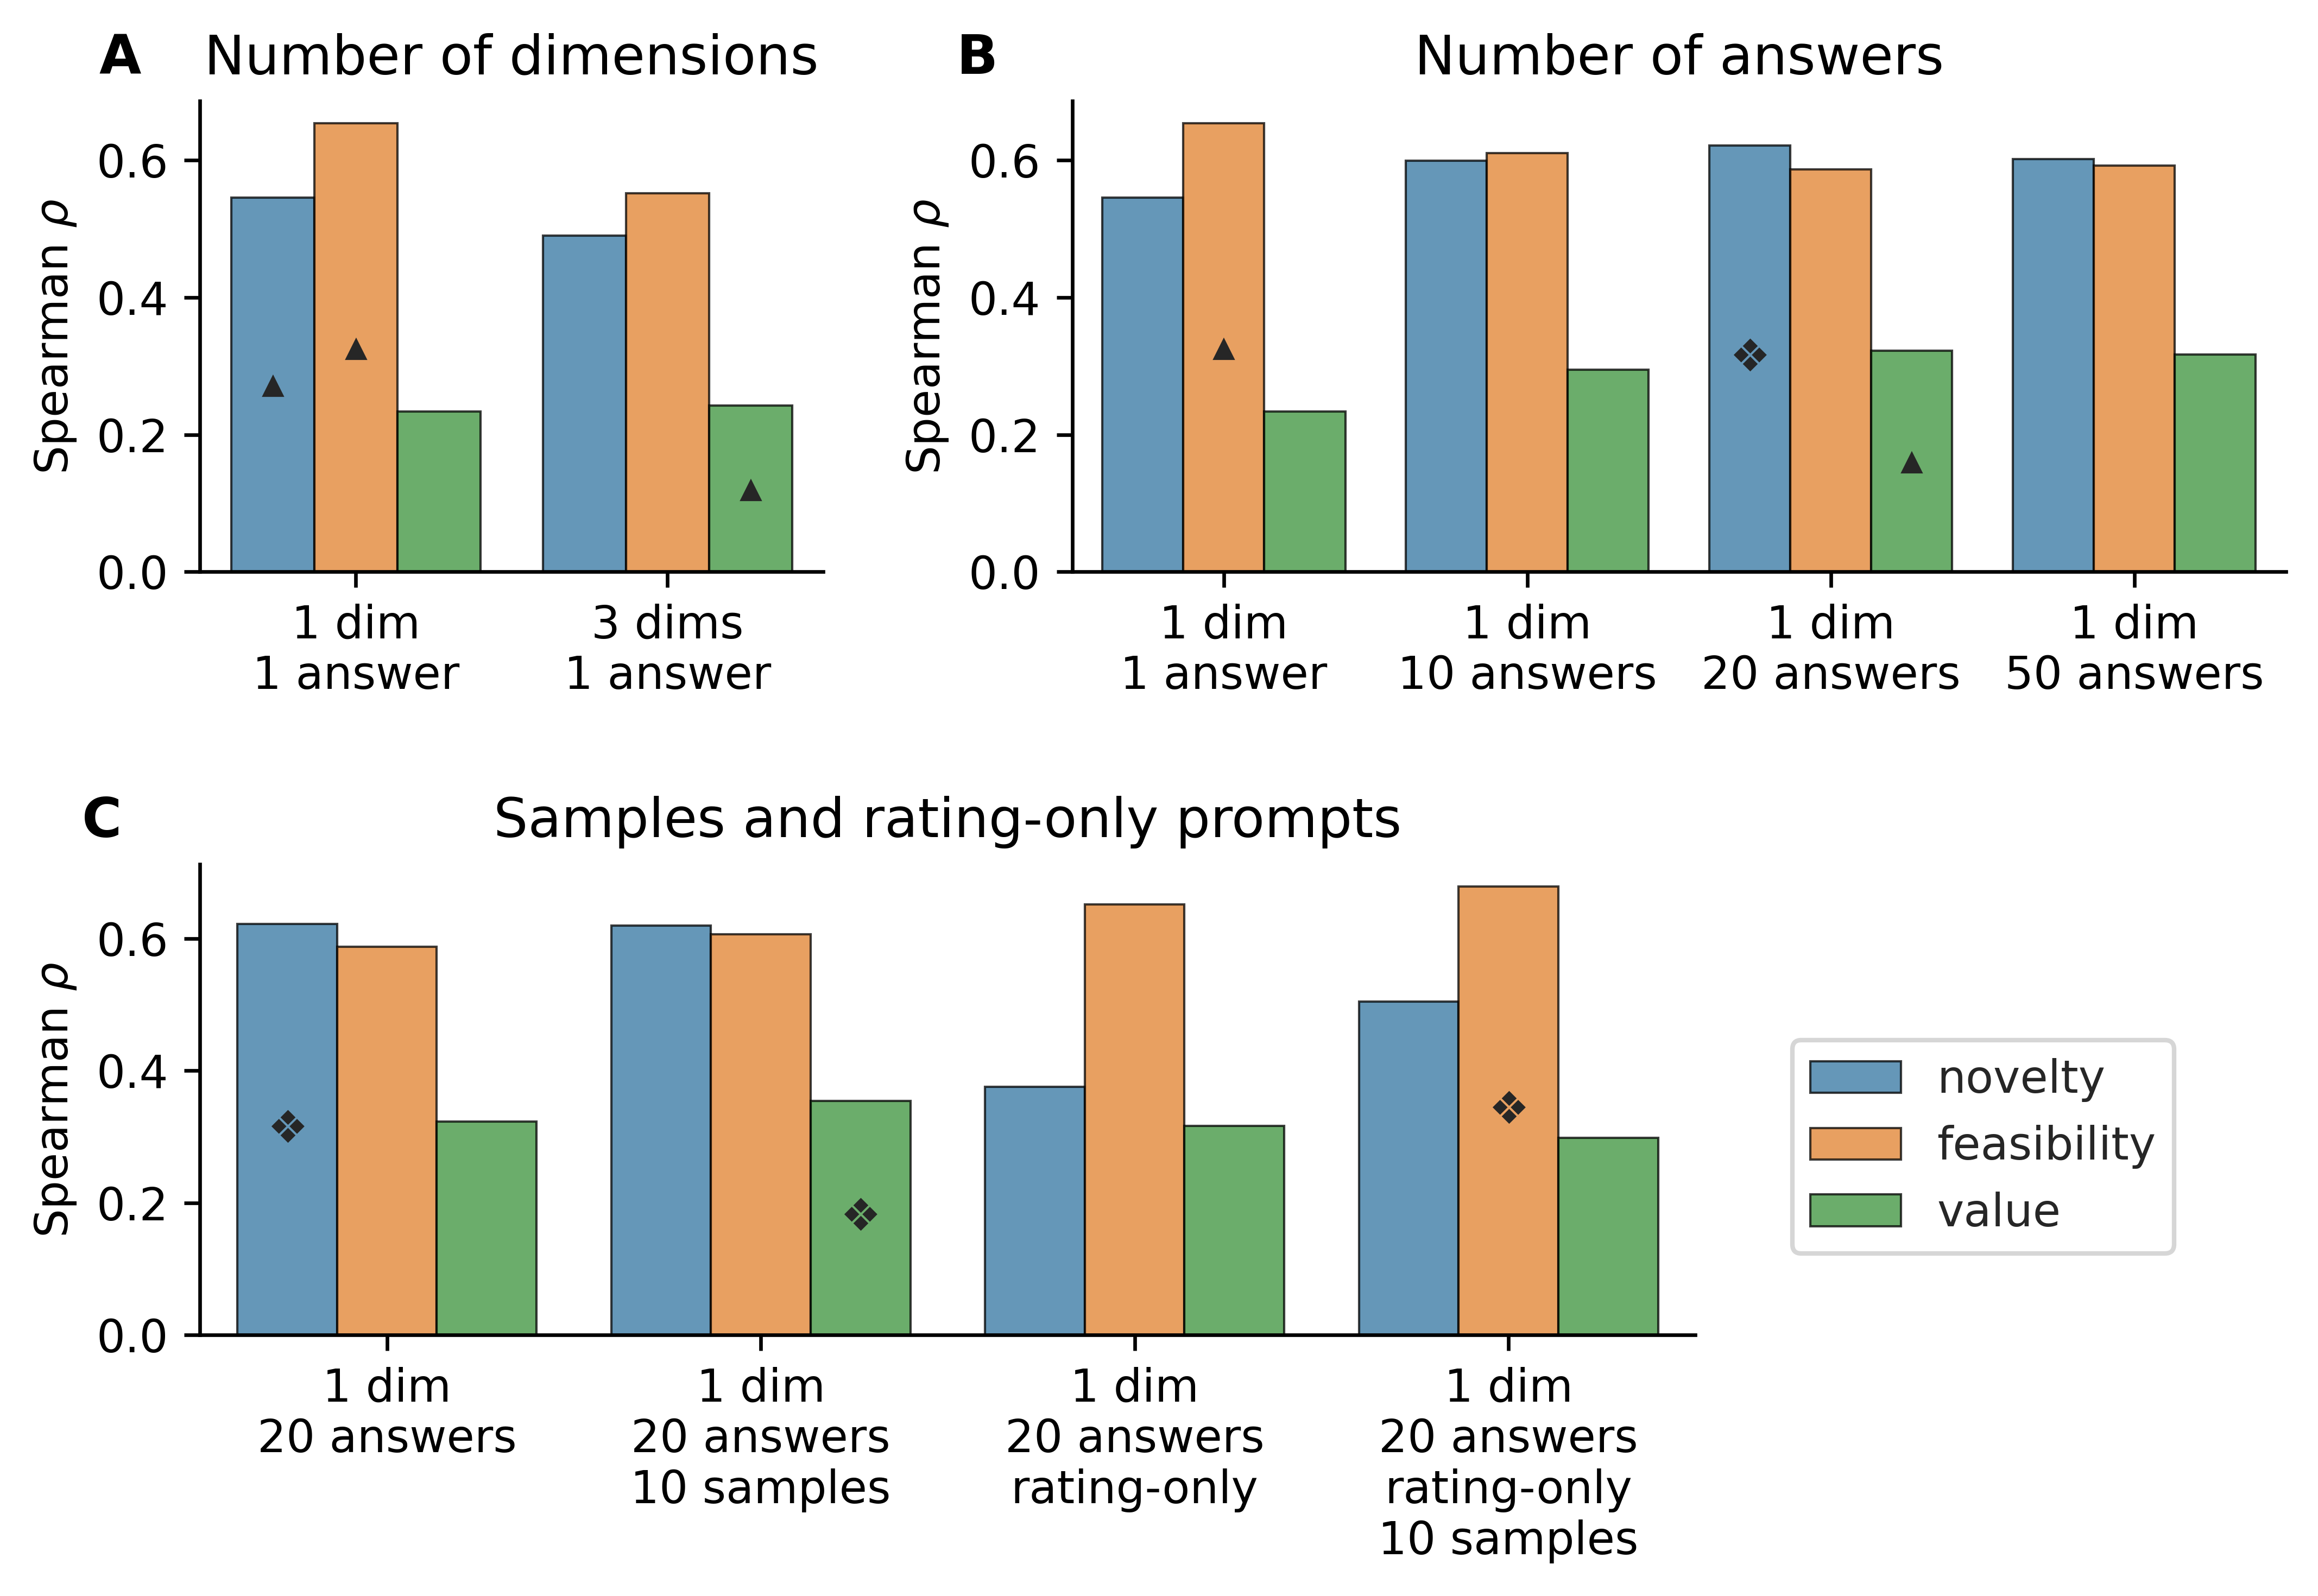

In [10]:
fig = plt.figure(figsize=(7,5), layout='constrained', dpi=600)
fig.get_layout_engine().set(h_pad=0.15)
gs = fig.add_gridspec(2,8)
axs = [fig.add_subplot(gs[0,:3]), fig.add_subplot(gs[0, 3:]), fig.add_subplot(gs[1, :6]), fig.add_subplot(gs[1, 6:])]
sns.set_style('whitegrid')

for iax, (ax, (comp, title)) in enumerate(zip(axs, comparisons.items())):
    ax.set_title(title)
    plot_utils.label_panel(ax, iax)

    thecorr = spearman.loc[[methods[s] for s in comp]]
    long = thecorr.melt(value_name='Spearman $\\rho$', var_name='measure', ignore_index=False)
    sns.barplot(long, x=long.index, y='Spearman $\\rho$', hue='measure', ax=ax, alpha=.75, edgecolor='k', lw=.5)
    
    # Mark maxima
    for i, col in enumerate(spearman.columns):
        jmax_local = thecorr[col].argmax()
        jmax = jmax_local if spearman.iloc[spearman[col].argmax()].name in thecorr.index else -1
        labels = ['❖' if j == jmax else '▴' if j == jmax_local else '' for j in range(len(thecorr))]
        ax.bar_label(ax.containers[i], labels, label_type='center')

    
    # Hide legends
    bars = ax.containers
    for method in ax.get_children():
        if isinstance(method, mpl.legend.Legend):
            method.set_visible(False)
    
    ax.set_xlabel('')

axs[-1].legend(bars, measures, loc='center left', bbox_to_anchor=(-.4, .4))
axs[-1].grid(False)
axs[-1].set_xticks([])
axs[-1].set_yticks([])
sns.despine()
sns.despine(ax=axs[-1], bottom=True, left=True)
plt.savefig('Figure_3.pdf')

In [11]:
spearman_qid

,method,novelty,feasibility,value
0,3 dims\n1 answer,0.293516,0.368488,0.132958
1,3 dims\n1 answer,0.702964,0.755799,0.348636
2,3 dims\n1 answer,0.502738,0.512956,0.327210
3,3 dims\n1 answer,0.628051,0.622660,0.301587
4,3 dims\n1 answer,0.377557,0.651323,0.193605
...,...,...,...,...
235,1 dim\n20 answers\nrating-only\n10 samples,0.436241,0.586452,0.785249
236,1 dim\n20 answers\nrating-only\n10 samples,0.535330,0.676605,0.035604
237,1 dim\n20 answers\nrating-only\n10 samples,0.754183,0.804624,0.196437
238,1 dim\n20 answers\nrating-only\n10 samples,0.765539,0.720914,-0.175640


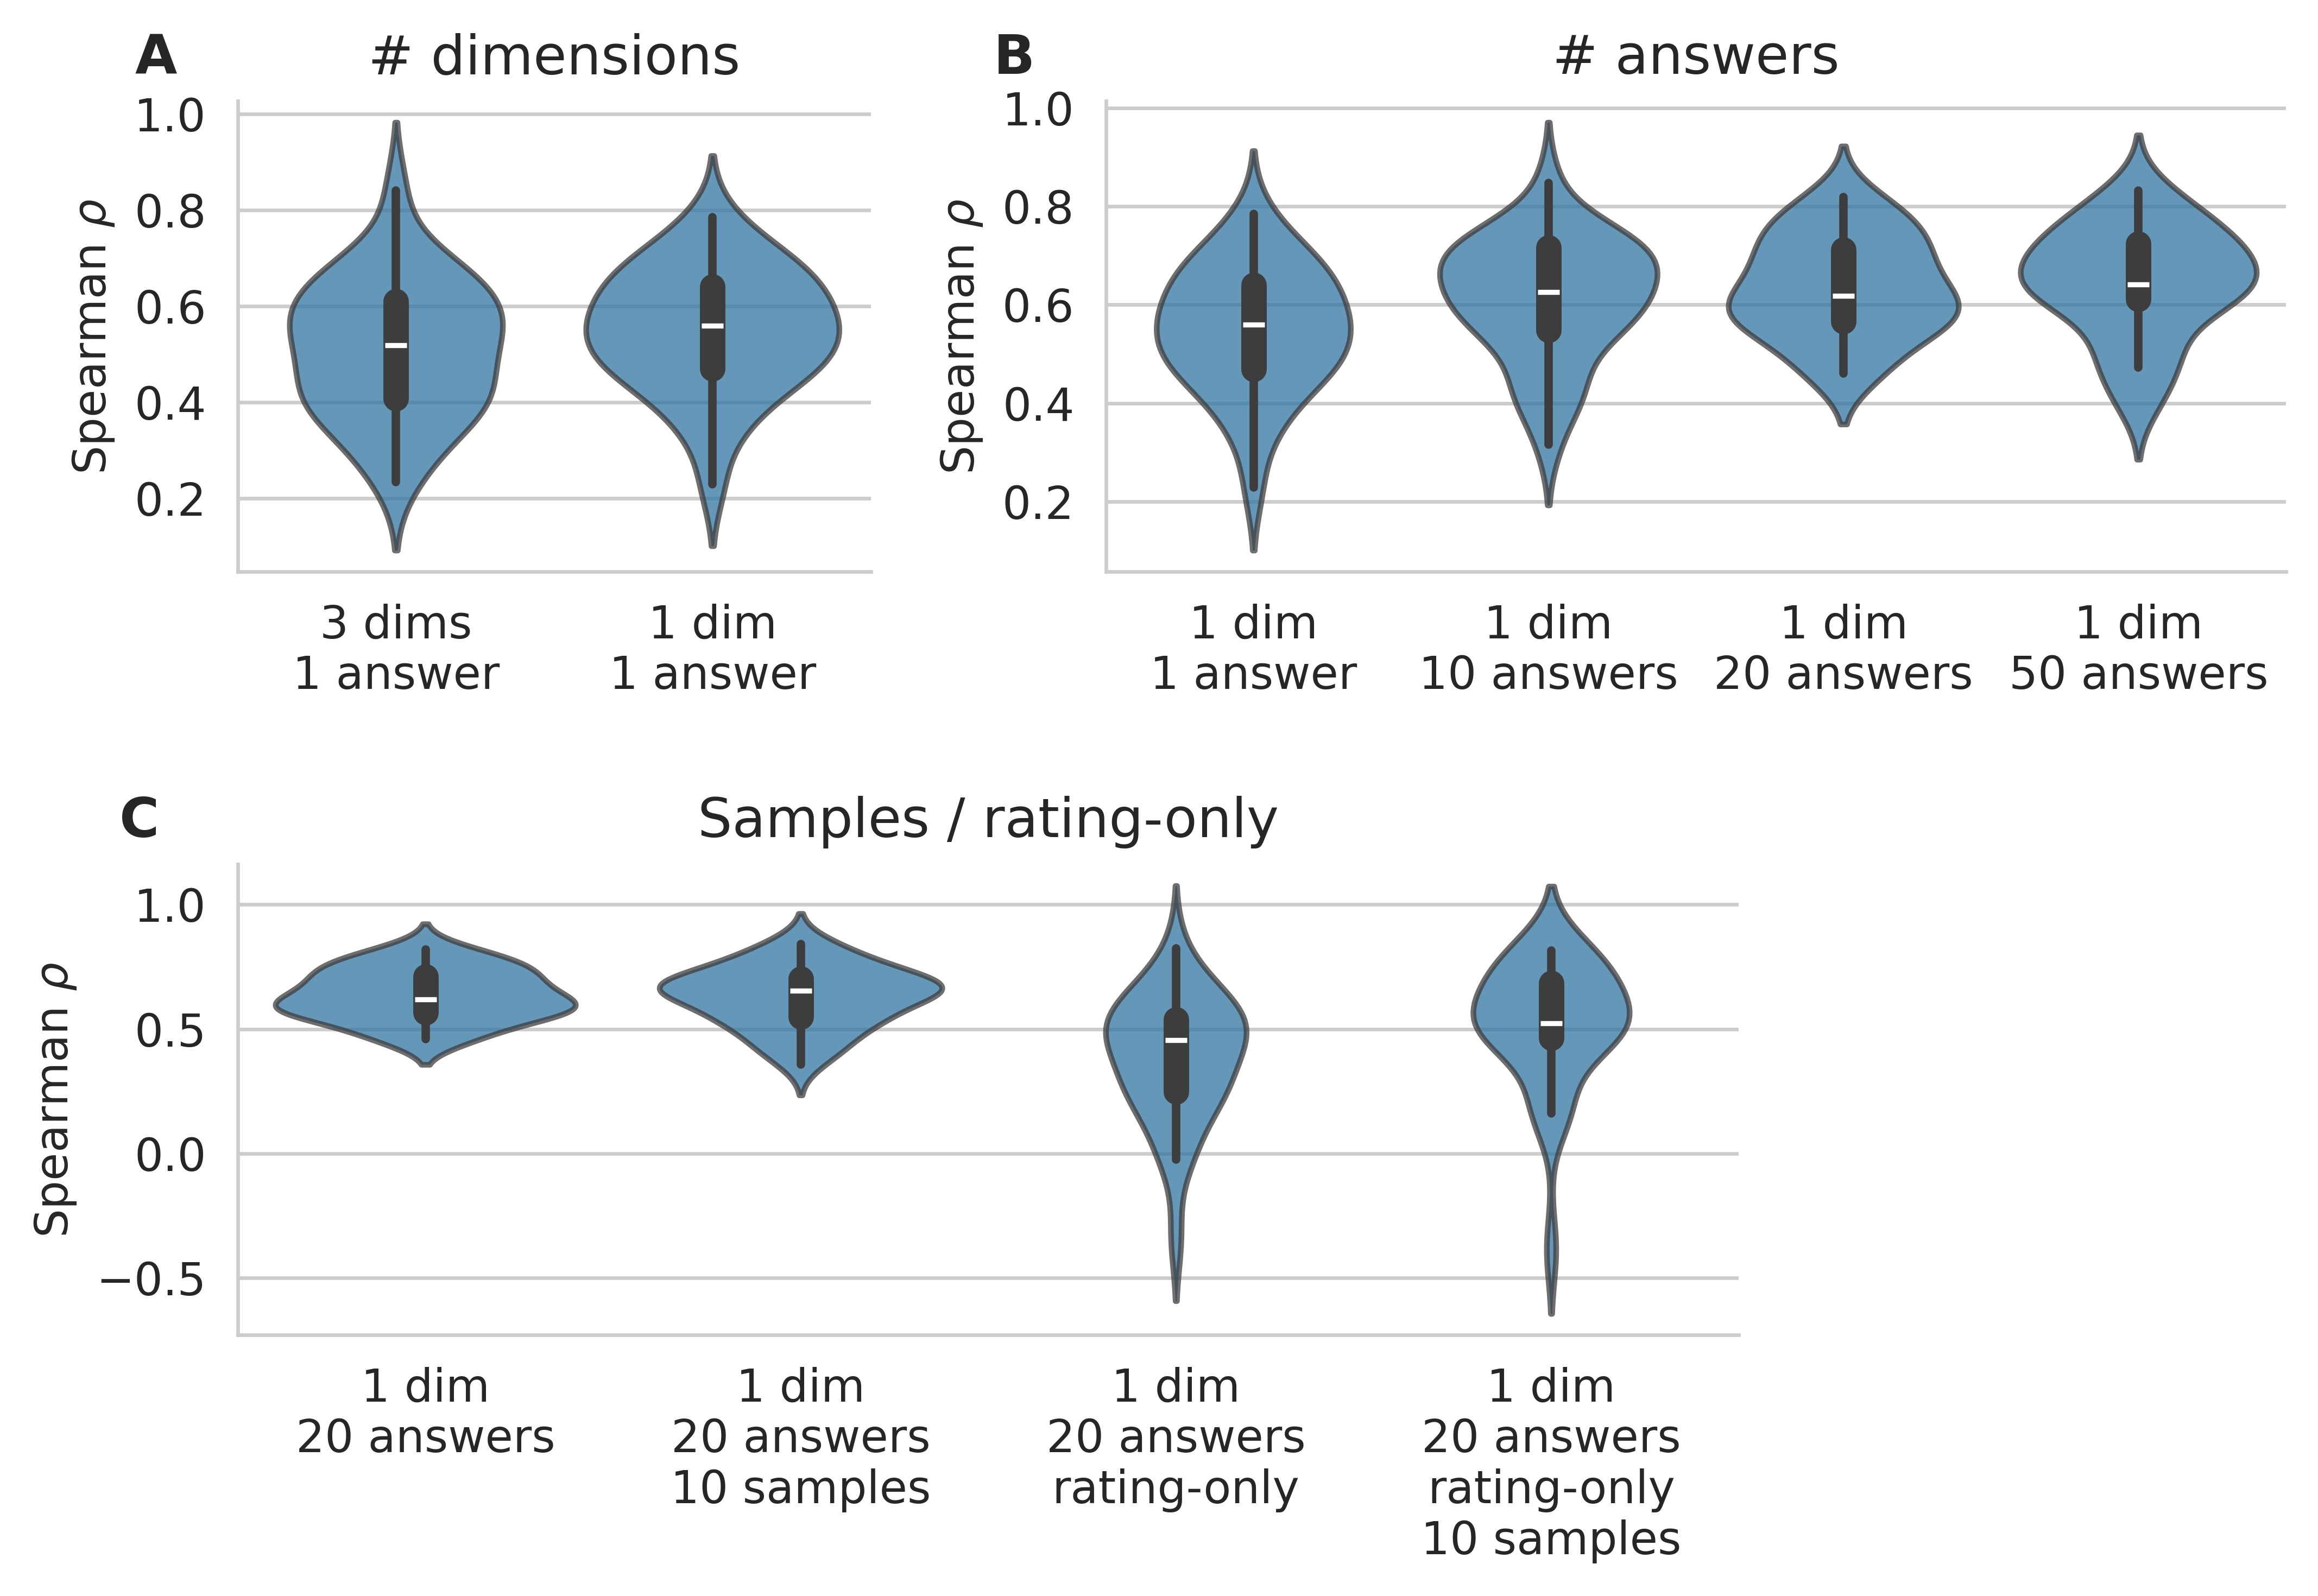

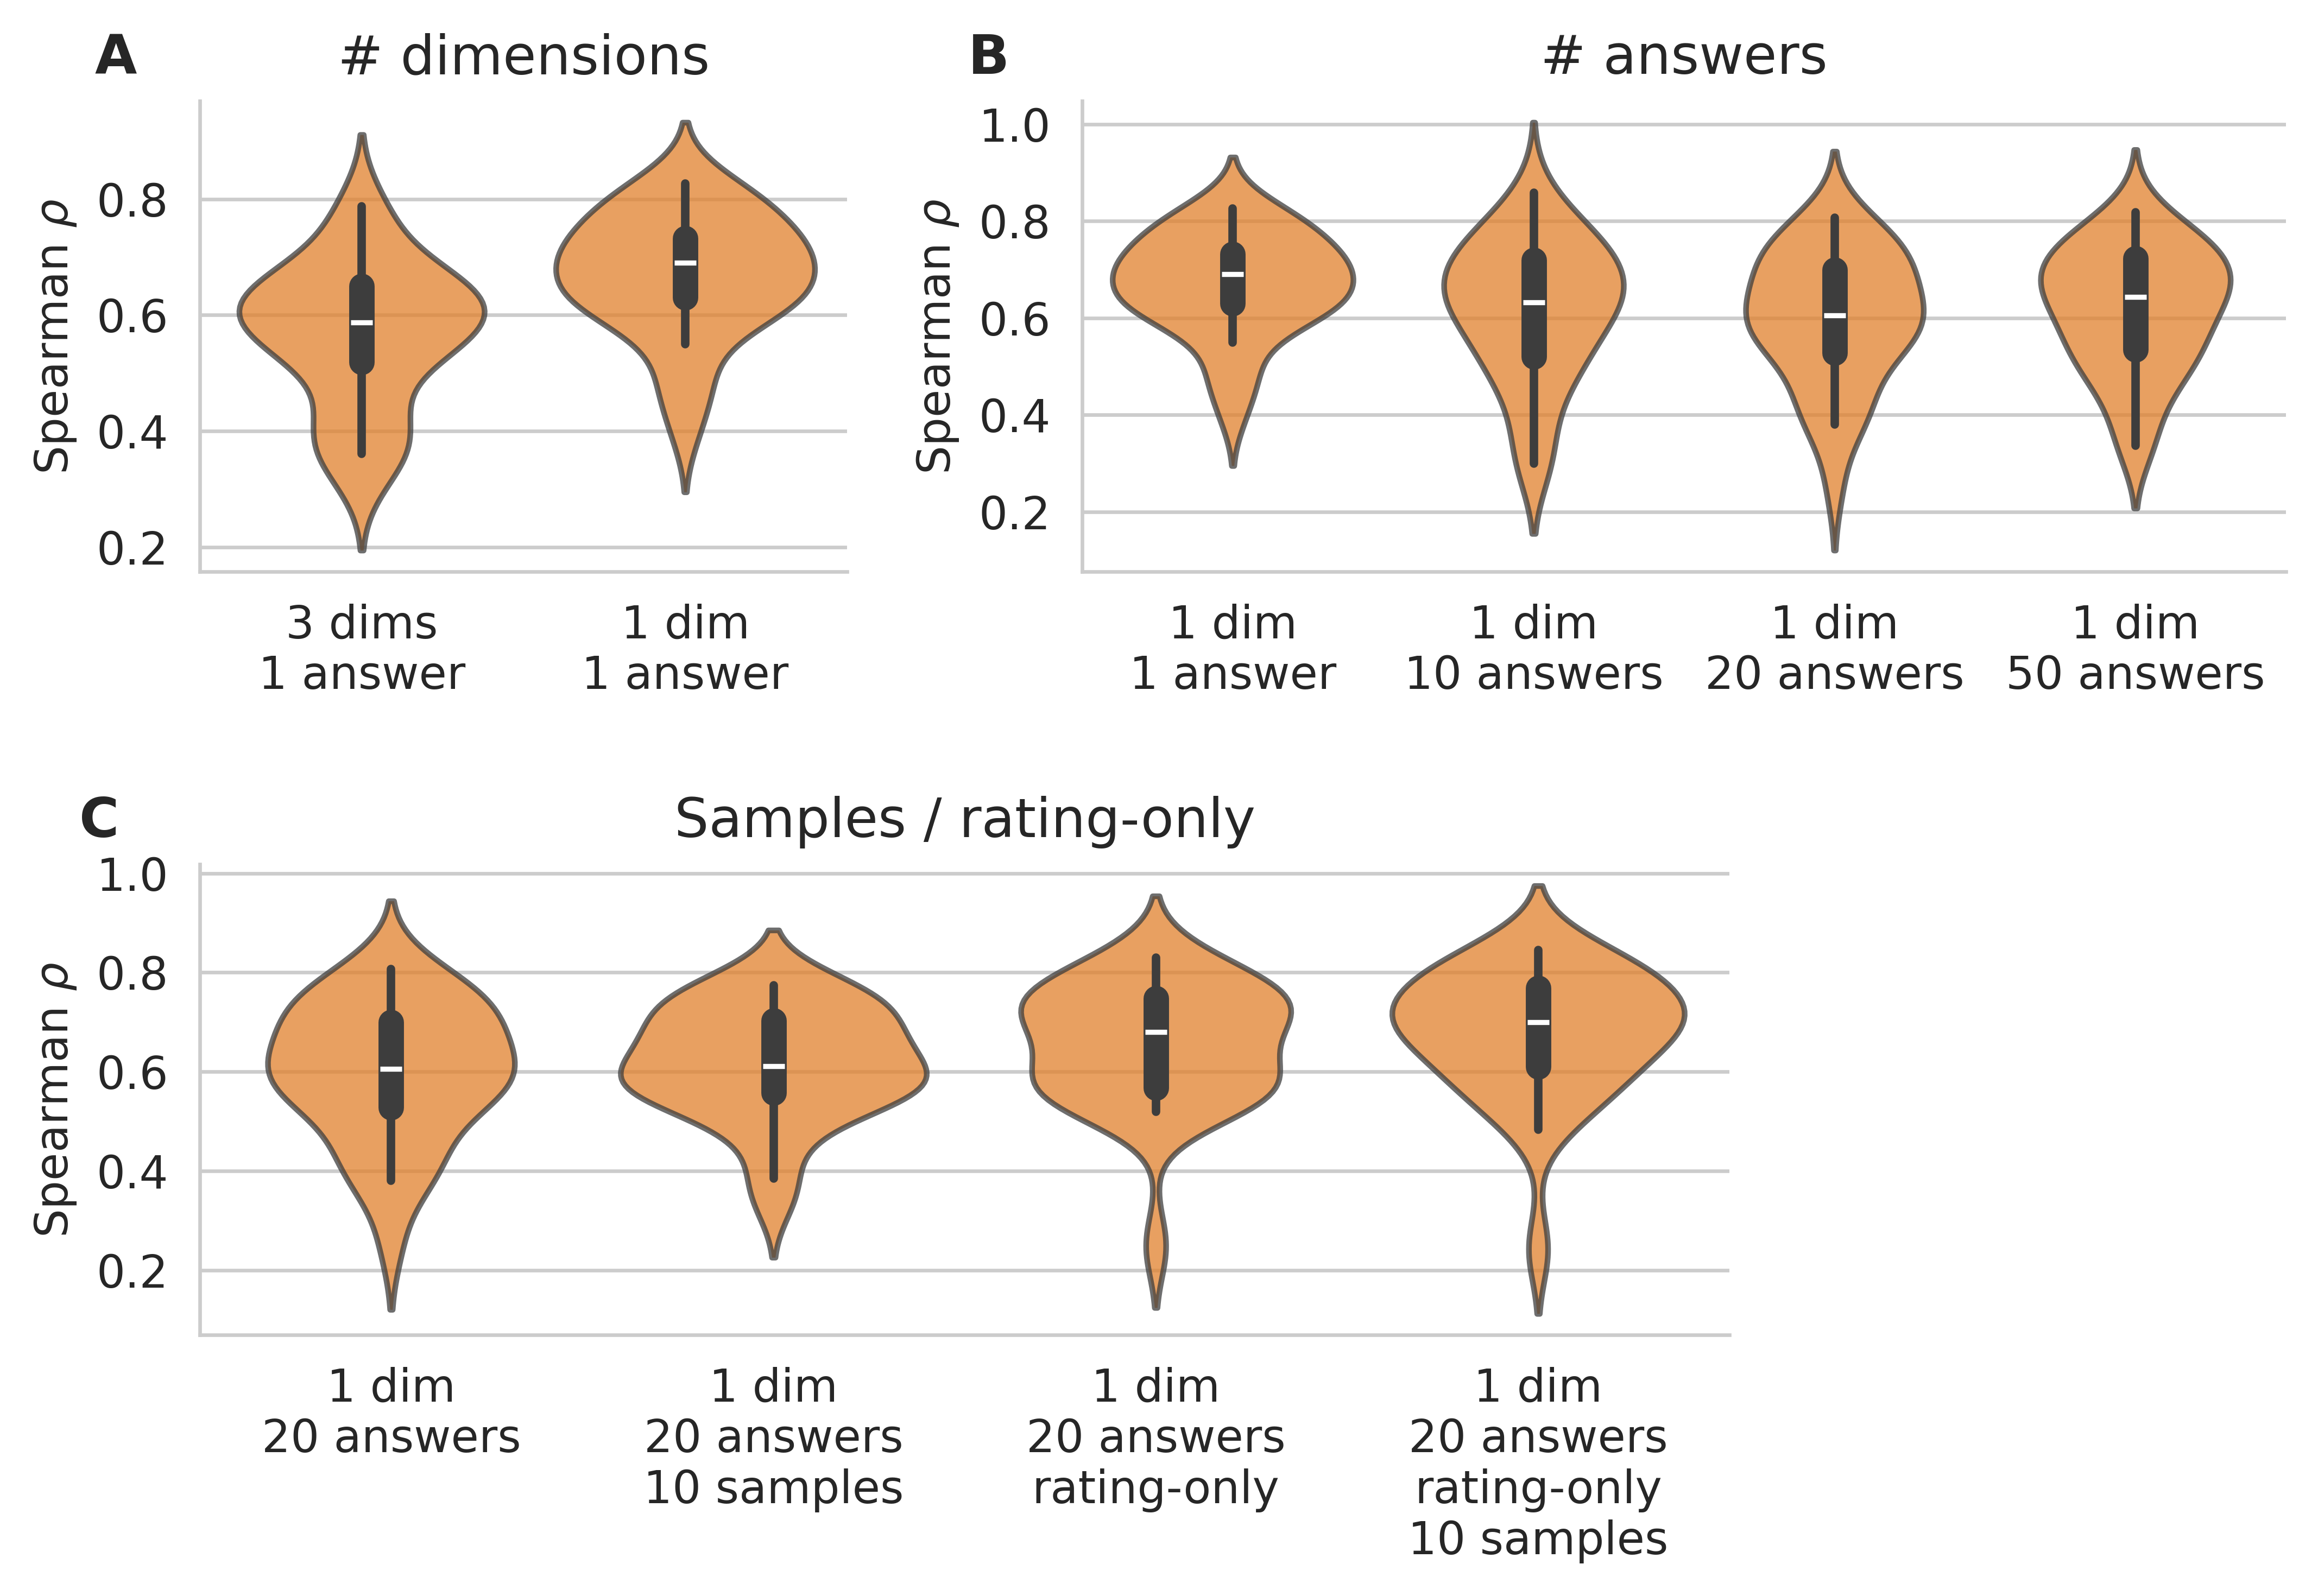

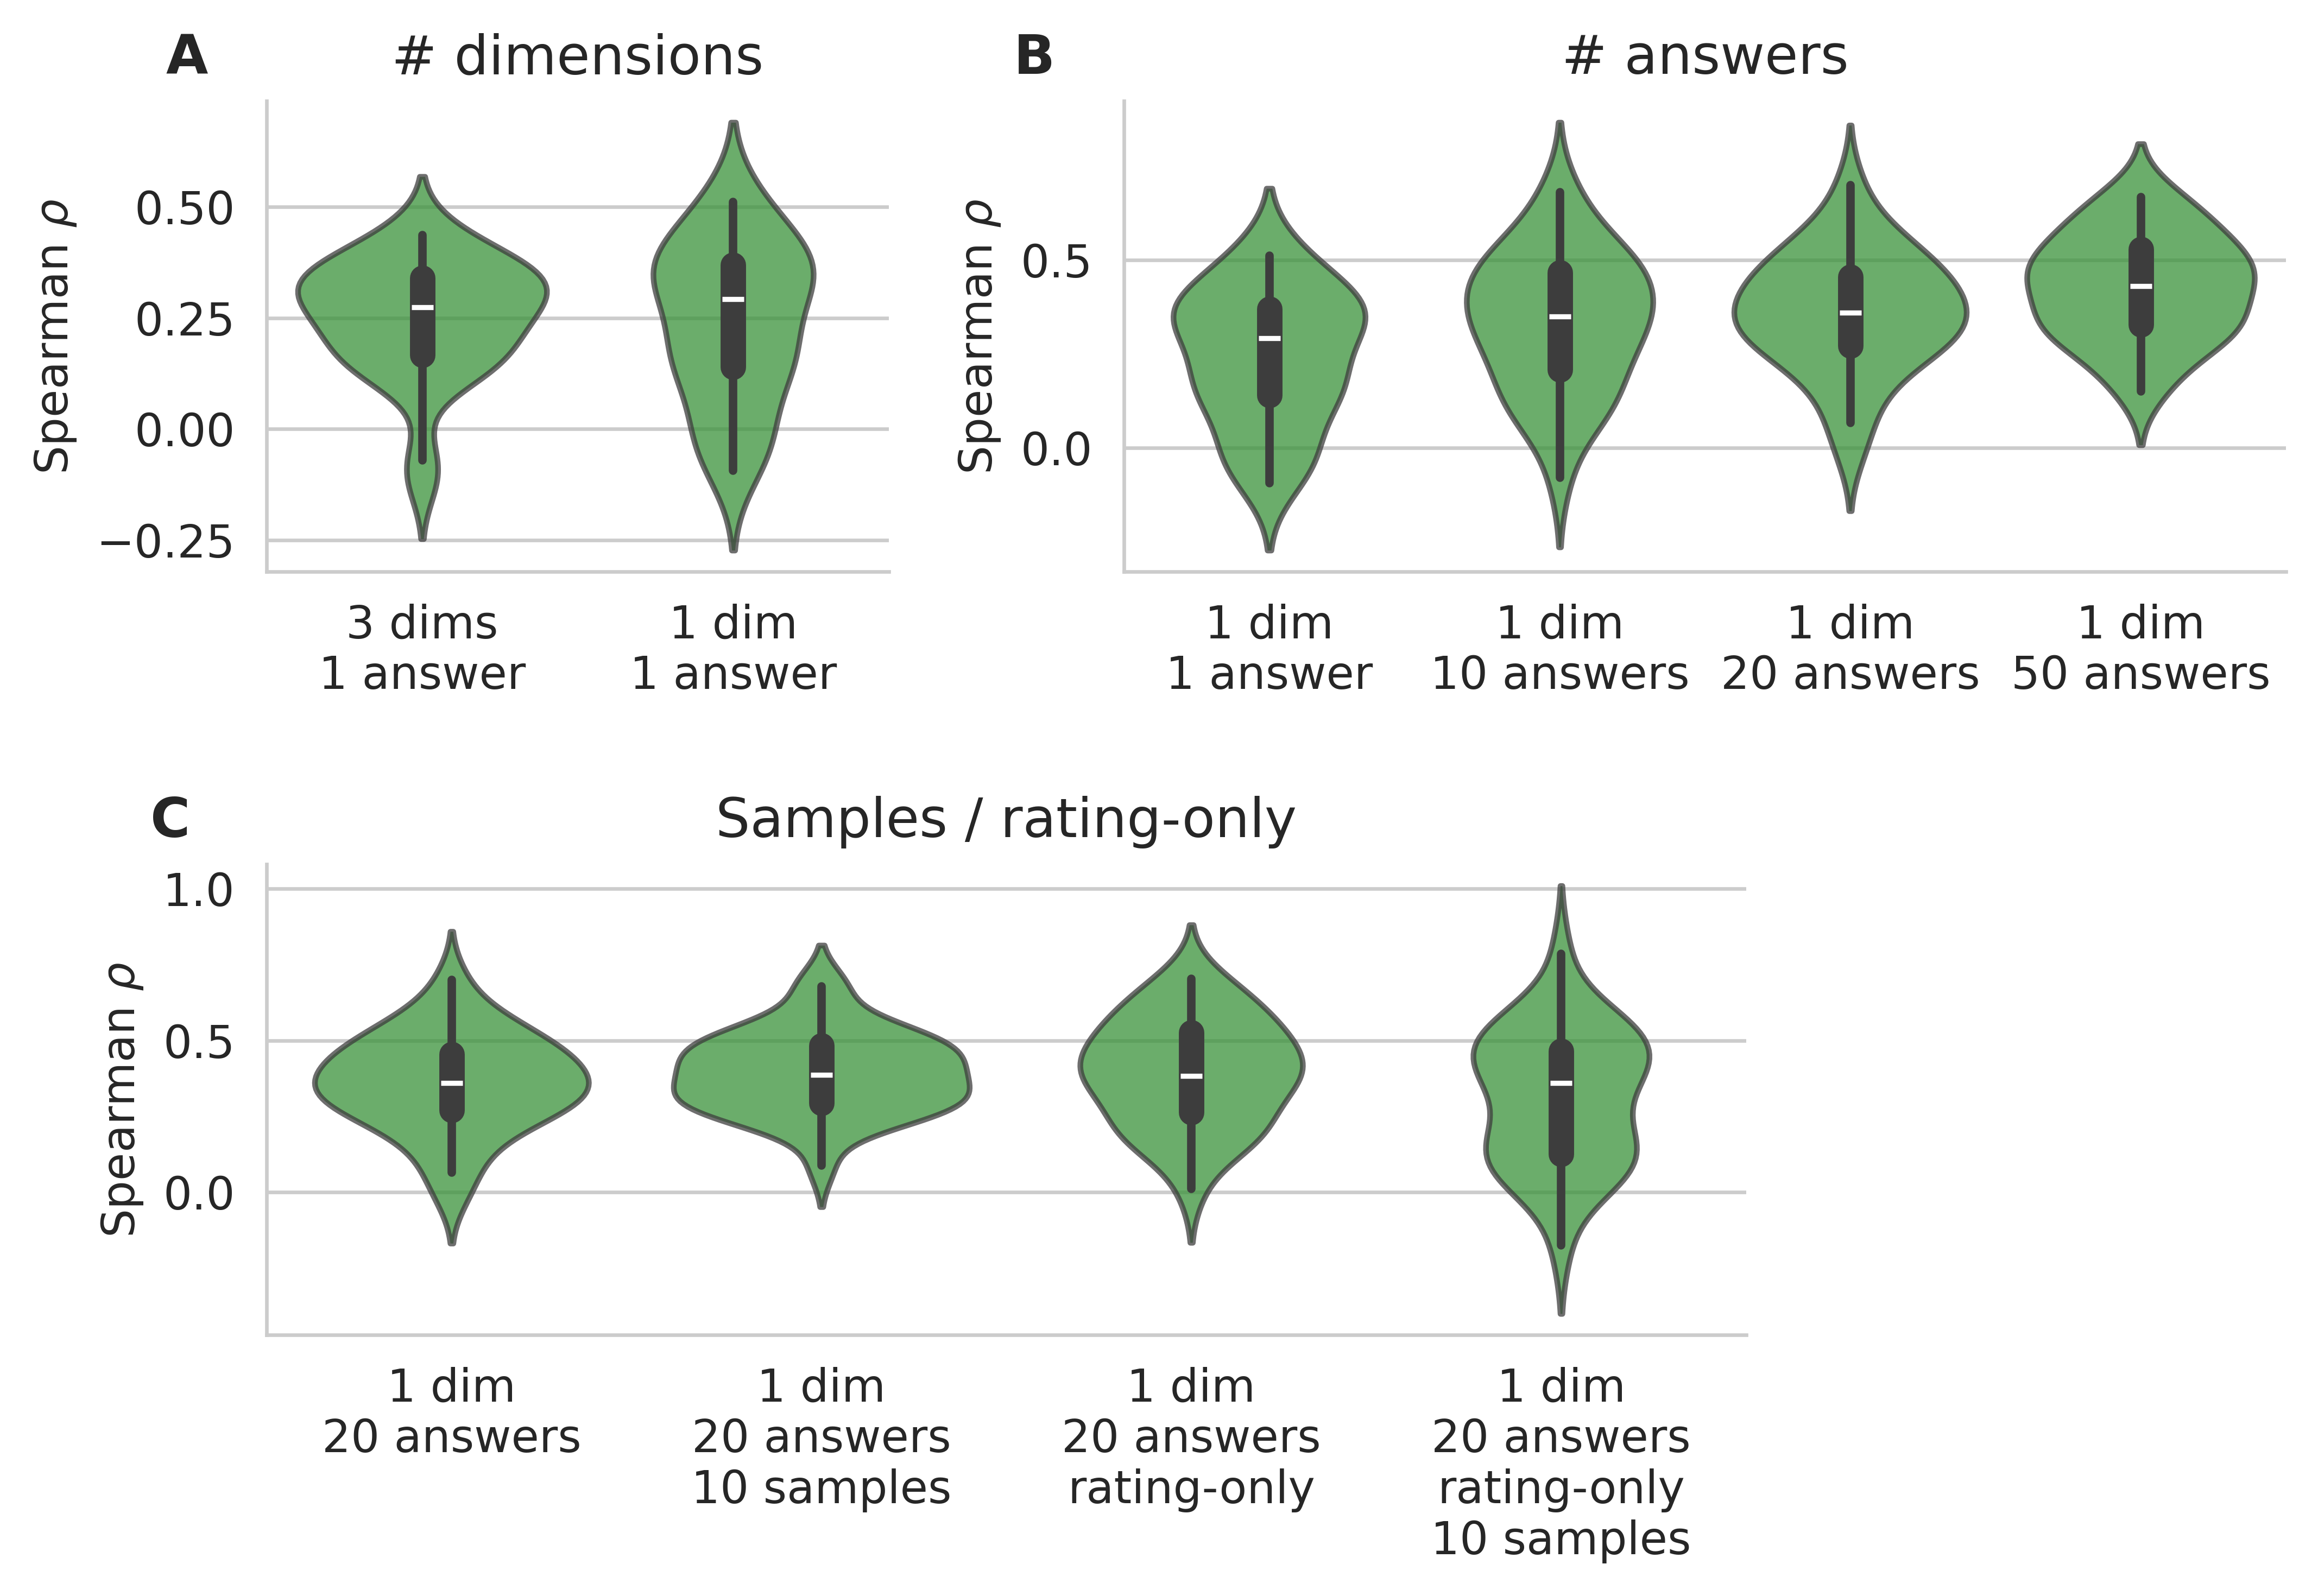

In [13]:
for key in measures:
    fig = plt.figure(figsize=(7,5), layout='constrained', dpi=600)
    fig.get_layout_engine().set(h_pad=0.15)
    gs = fig.add_gridspec(2,8)
    axs = [fig.add_subplot(gs[0,:3]), fig.add_subplot(gs[0, 3:]), fig.add_subplot(gs[1, :6])]
    # gs = fig.add_gridspec(1,3)
    # axs = [fig.add_subplot(gs[0,i]) for i in range(3)]
    sns.set_style('whitegrid')

    long = spearman_qid.melt(id_vars='method', value_name='Spearman $\\rho$', var_name='measure')

    for iax, (ax, (comp, title)) in enumerate(zip(axs, comparisons.items())):
        ax.set_title(short_titles[title])
        plot_utils.label_panel(ax, iax)

        comp_lb = [methods[c] for c in comp]
        df = long[(long['measure']==key) & long['method'].isin(comp_lb)]
        sns.violinplot(df, x=df.method, y='Spearman $\\rho$', hue='measure', hue_order=measures, legend=False, ax=ax, alpha=.75)

        ax.set_xlabel('')

    sns.despine()
    plt.savefig(f'Figure_3.qid-{key}.pdf')

In [13]:
methods_flat = {k: v.replace('\n',', ') for k,v in methods.items()}

for meth in (('n_1r1i', 'n_3r1i'), ('n_1r20i', 's_1r20i'), ('n_1r20i', 'n_1r20i_numeric')):
    print(f'Comparing [{methods_flat[meth[0]]}] to [{methods_flat[meth[1]]}]')
    d0, d1 = [spearman_qid[spearman_qid['method'] == methods[m]] for m in meth]
    for measure in measures:
        test = stats.ttest_rel(d0[measure], d1[measure])
        d = test.statistic/np.sqrt(len(d0))
        print(f'{measure}, t = {test.statistic:.2g}, p = {test.pvalue:.2g}, d = {d:.2g}')
    print()

Comparing [1 dim, 1 answer] to [3 dims, 1 answer]
novelty, t = 1.5, p = 0.16, d = 0.27
feasibility, t = 5.4, p = 8e-06, d = 0.99
value, t = -0.32, p = 0.75, d = -0.059

Comparing [1 dim, 20 answers] to [1 dim, 20 answers, 10 samples]
novelty, t = 0.51, p = 0.62, d = 0.092
feasibility, t = -1.5, p = 0.14, d = -0.27
value, t = -1.3, p = 0.21, d = -0.23

Comparing [1 dim, 20 answers] to [1 dim, 20 answers, rating-only]
novelty, t = 5.5, p = 6e-06, d = 1
feasibility, t = -2.7, p = 0.011, d = -0.5
value, t = -0.77, p = 0.44, d = -0.14



In [37]:
mean = spearman_qid.groupby('method').mean()

In [38]:
std = spearman_qid.groupby('method').std()

In [45]:
print('\t'.join(['Method'] + [m.capitalize() for m in measures]))
for method in methods.values():
    m = method.replace('\n', ', ')
    print(m, end='')
    for measure in measures:
        print(f'\t{mean.loc[method, measure]:.2f} ± {std.loc[method, measure]:.2f}', end='')
    print()

Method	Novelty	Feasibility	Value
3 dims, 1 answer	0.51 ± 0.14	0.57 ± 0.12	0.25 ± 0.13
1 dim, 1 answer	0.55 ± 0.13	0.67 ± 0.10	0.24 ± 0.18
1 dim, 10 answers	0.61 ± 0.12	0.62 ± 0.14	0.33 ± 0.18
1 dim, 20 answers	0.64 ± 0.10	0.60 ± 0.14	0.36 ± 0.16
1 dim, 50 answers	0.65 ± 0.11	0.62 ± 0.13	0.43 ± 0.14
1 dim, 20 answers, 10 samples	0.63 ± 0.12	0.62 ± 0.11	0.39 ± 0.13
1 dim, 20 answers, rating-only	0.38 ± 0.25	0.65 ± 0.12	0.39 ± 0.17
1 dim, 20 answers, rating-only, 10 samples	0.52 ± 0.25	0.68 ± 0.13	0.31 ± 0.22


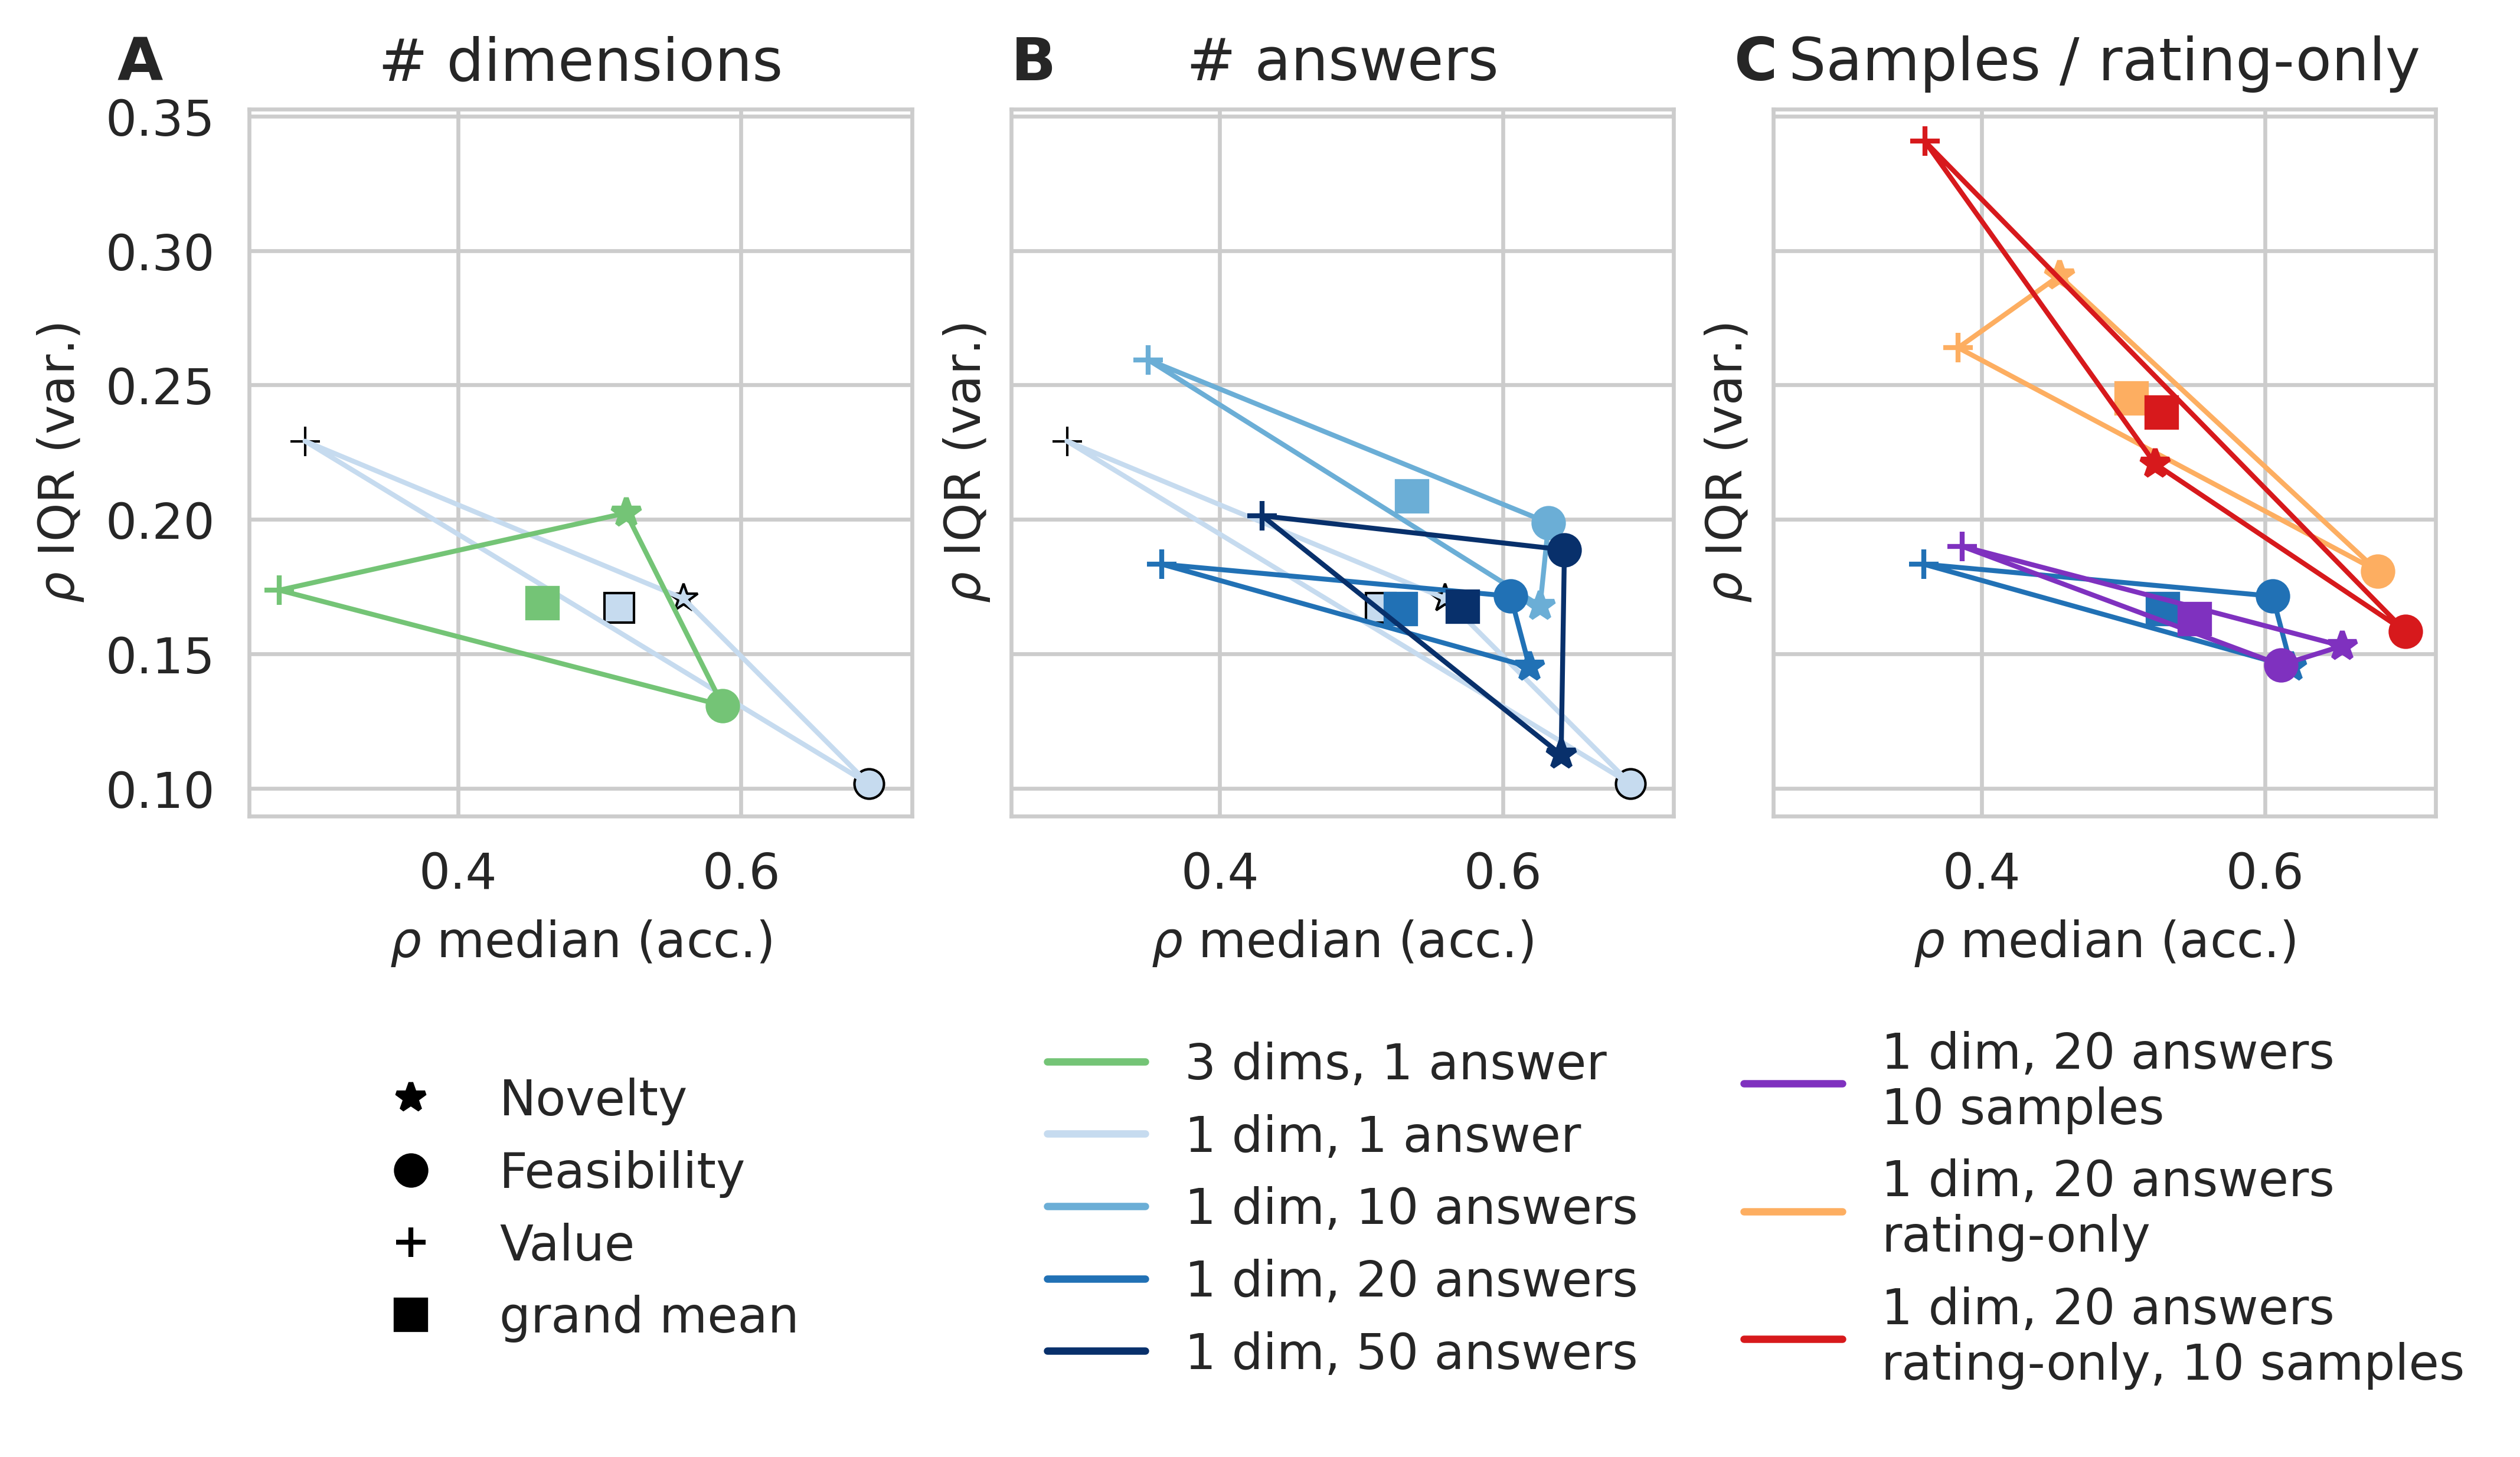

In [46]:
fig, axs = plt.subplots(2,3, figsize=(7,4), height_ratios=(1,.6), layout='constrained', dpi=600, sharex='row', sharey='row')
symbols = '*o+'
blues = ['#c6dbef', '#6baed6', '#2171b5', '#08306b']  # light to dark, 1-10-20-50
lightgreen = '#74c476'  # to match blue-1 (but darker)
purple = '#7f31bf'  # to match blue-20
reds = ['#fdae61', '#d7191c']  # light, dark
colors = {
    'n_3r1i': lightgreen,
    **{f'n_1r{x}i': c for x, c in zip((1,10,20,50), blues)},
    **{f'{t}_1r20i_numeric': c for t, c in zip('ns', reds)},
    's_1r20i': purple
}
    
for iax, (ax, (comp, title)) in enumerate(zip(axs[0], comparisons.items())):
    ax.set_title(short_titles[title])
    plot_utils.label_panel(ax, iax)
    ax.set_xlabel('$\\rho$ median (acc.)')
    ax.set_ylabel('$\\rho$ IQR (var.)')
    # ax.set_xlabel('$\\rho$ mean (acc.)')
    # ax.set_ylabel('$\\rho$ stddev')
    
    for method in comp:
        label = methods[method]
        id = list(methods.keys()).index(method)
        edge_kw = {'mec': 'k', 'mew': 0.5} if method=='n_1r1i' else {}

        accuracy, variability = [], []
        for measure, m in zip(measures, symbols):
            grouped = spearman_qid.groupby('method')[measure]
            accuracy.append(grouped.median()[label])
            variability.append(grouped.quantile(.75)[label] - grouped.quantile(.25)[label])
            # accuracy.append(grouped.mean()[label])
            # variability.append(grouped.std()[label])
            ax.plot(accuracy[-1], variability[-1], m, c=colors[method], **edge_kw)
        
        center_of_gravity = np.mean(accuracy), np.mean(variability)
        ax.plot(*center_of_gravity, 's', c=colors[method], **edge_kw)

        accuracy.append(accuracy[0])
        variability.append(variability[0])
        
        ax.plot(accuracy, variability, c=colors[method], lw=1)

for measure, m in zip(measures, symbols):
    axs[1,0].plot([], m, c='k', label=measure.capitalize())
axs[1,0].plot([], 'sk', label='grand mean')

for i, (method, title) in enumerate(methods.items()):
    axs[1, 1 + int(i>4)].plot(
        [], c=colors[method], label=title.replace('\n',', ').replace('answers, ', 'answers\n'))

for ax in axs[1]:
    ax.legend(loc='center', frameon=False)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])